In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

paorder=['PRO','ALT']
papallete=[PRO_COLOR, ALT_COLOR]

In [7]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [8]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [9]:
df = pd.read_pickle('CCPA.pkl.gz')

In [10]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [11]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [12]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [13]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [14]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [15]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day       FL
5           e1, 10A         e1    10A  MIT0604  DE  Co_Culture  -10  0.37325
6           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -9  0.44400
7           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -8  0.69700
8           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -7  0.95000
9           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -6  1.20300

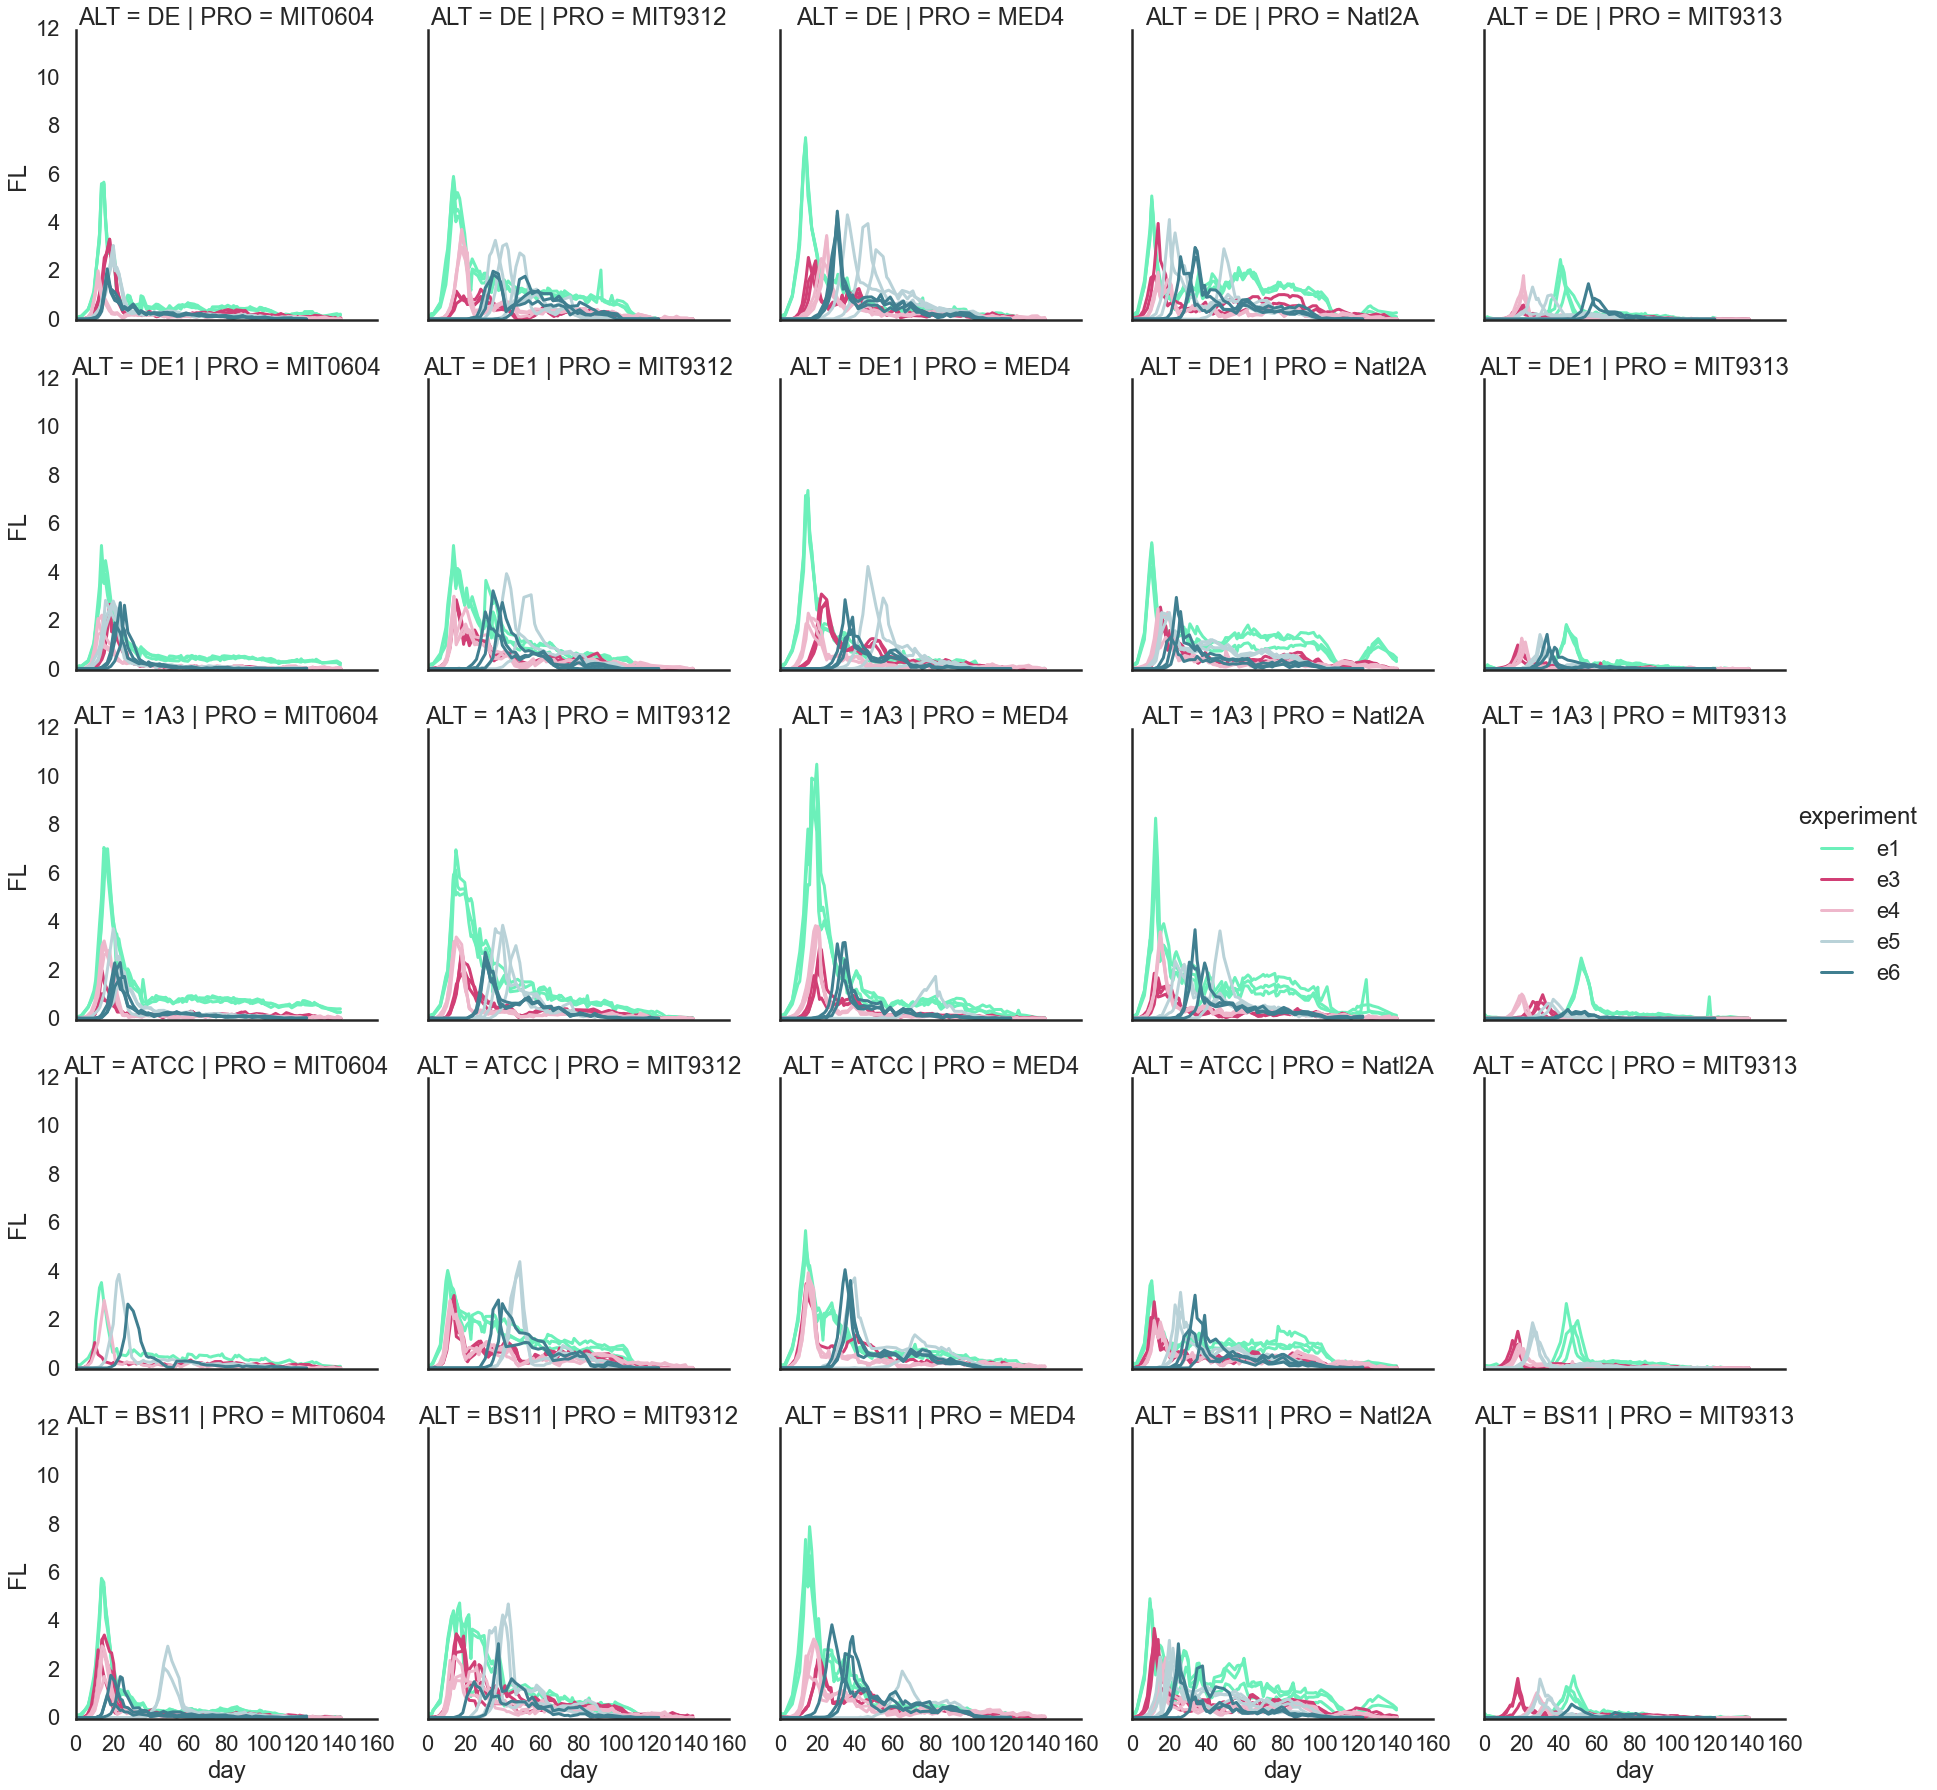

In [16]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

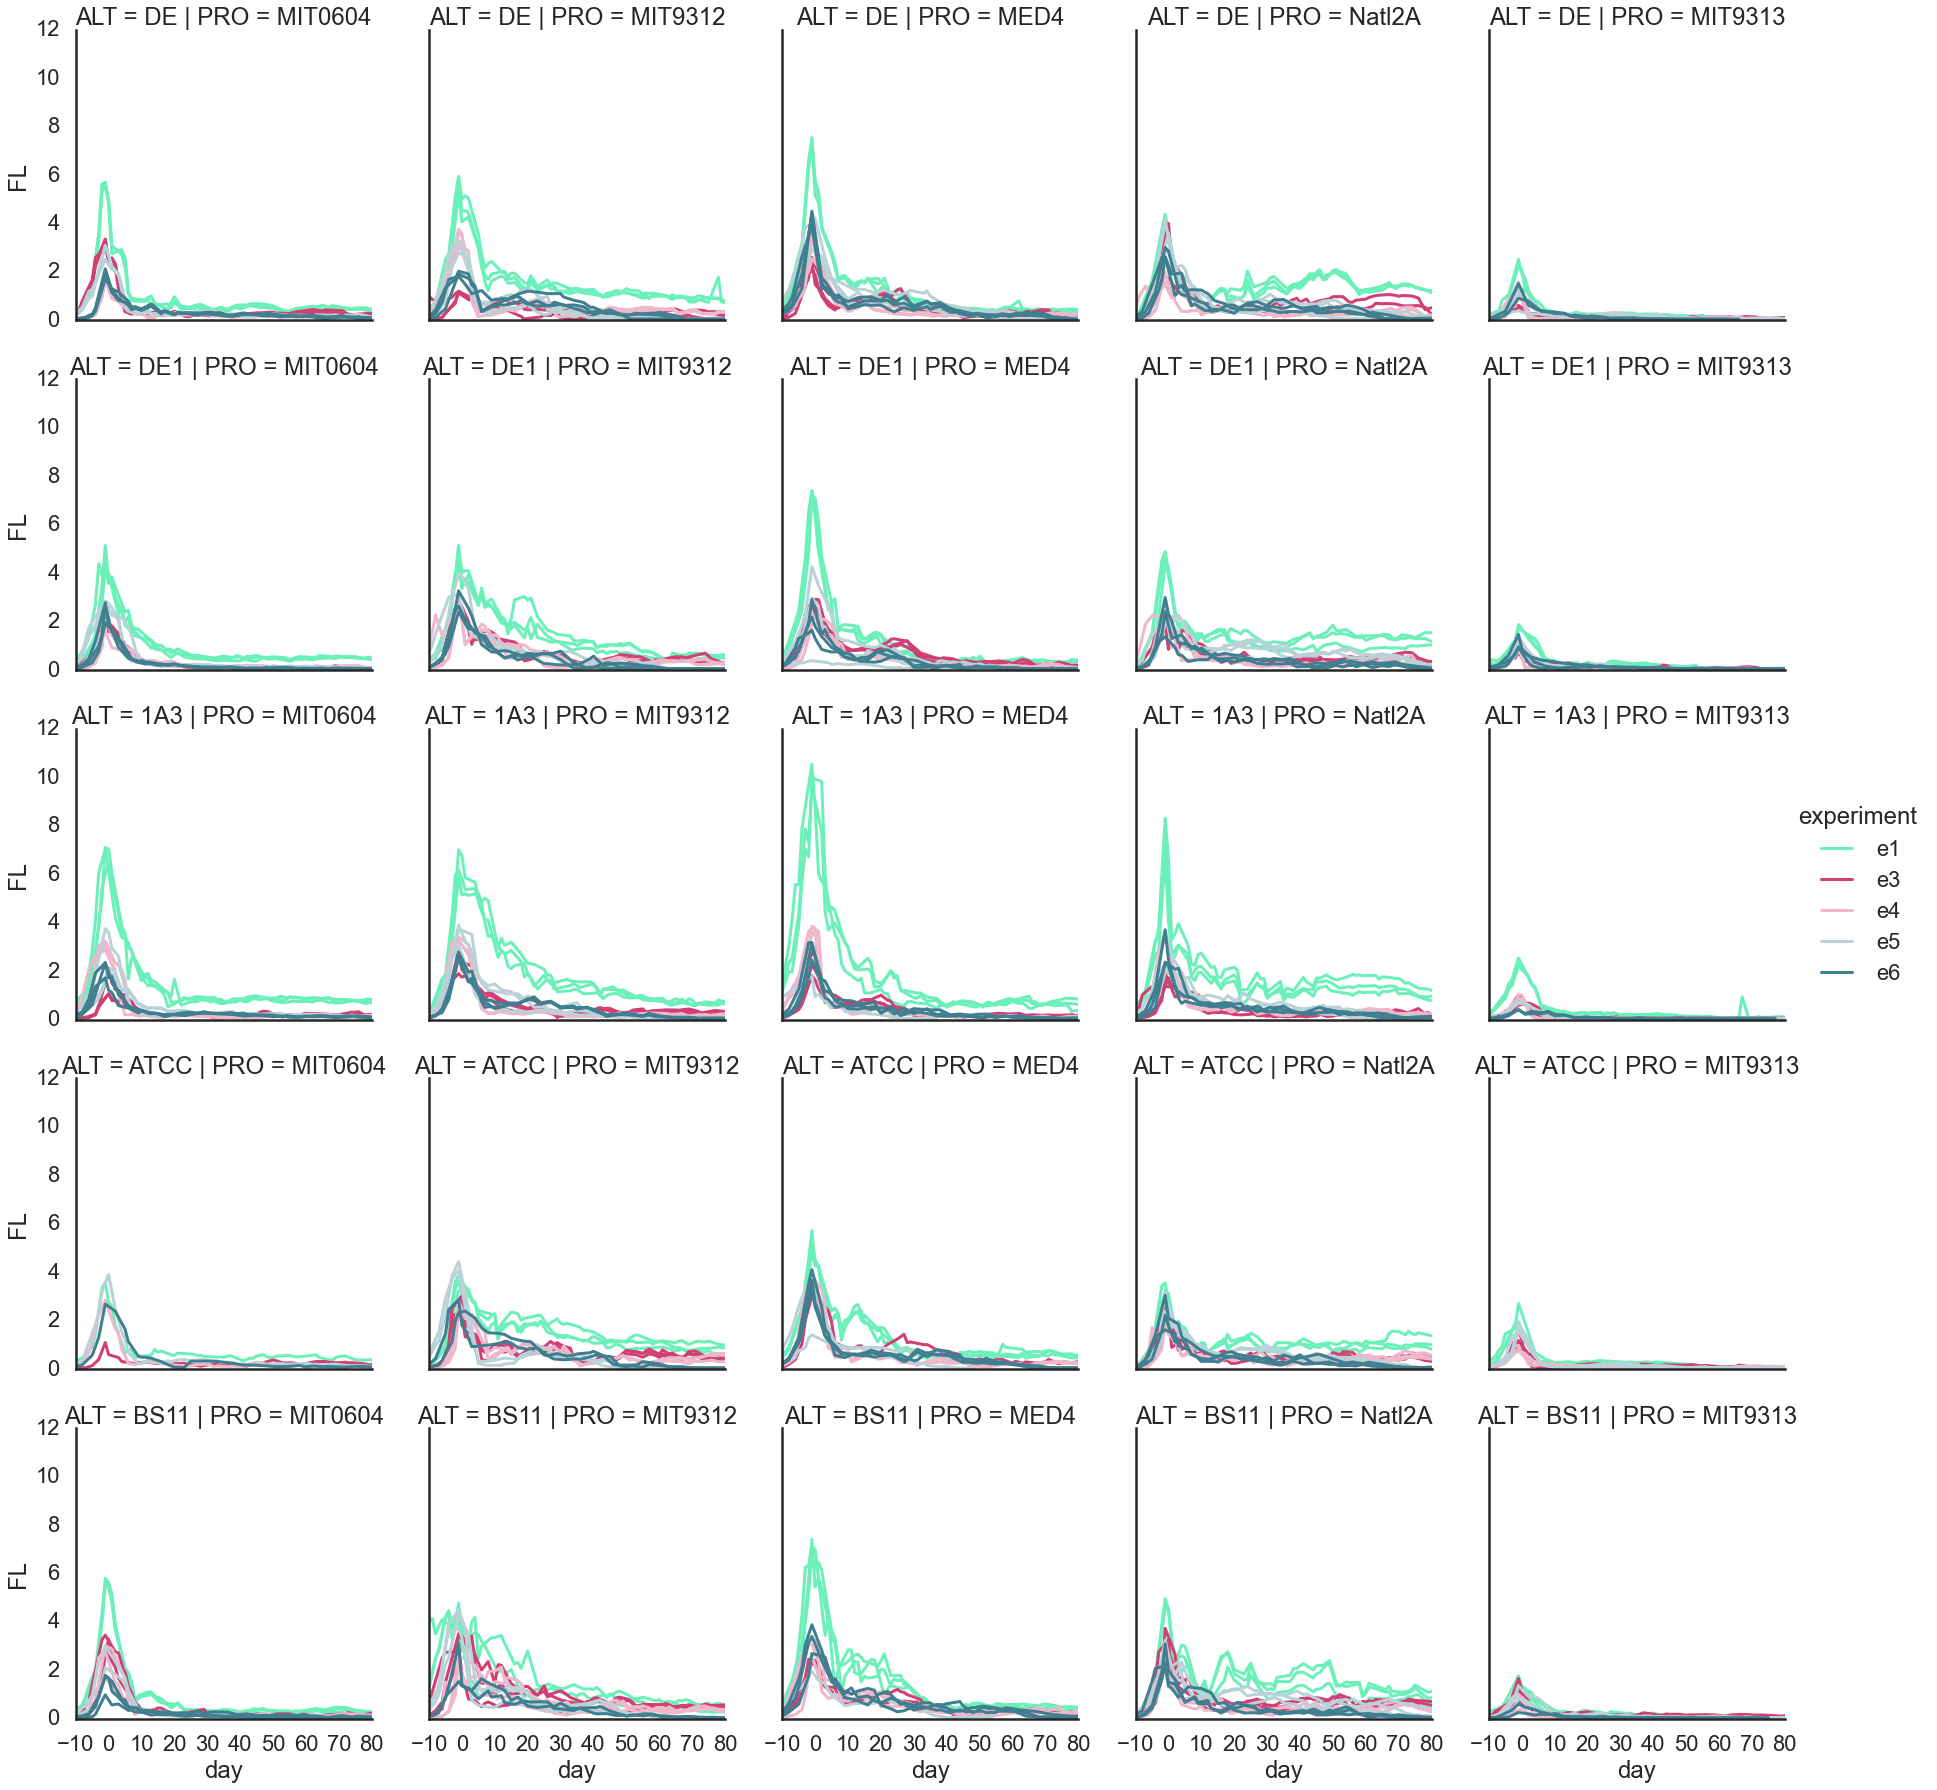

In [17]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

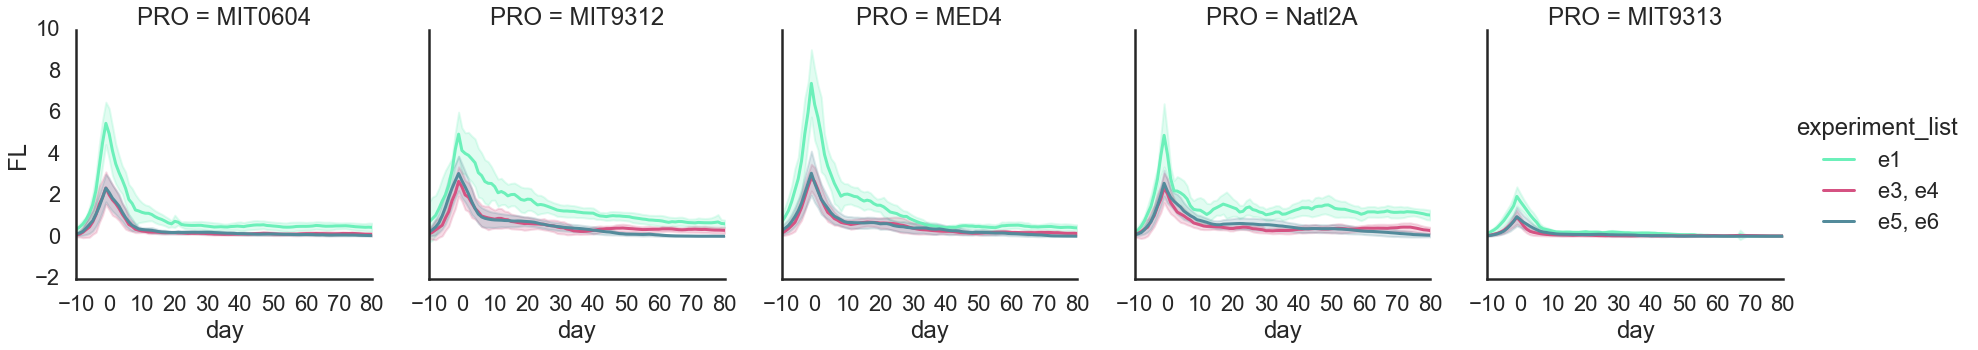

In [18]:
ds['experiment_list'] = ''
ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'
ds.loc[ds.experiment.isin(['e1']), 'experiment_list'] = 'e1'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', #aspect=1.8,
            x='day', y='FL', kind='line', col='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                col_order=porder,
               )
#g.set(yscale='log')

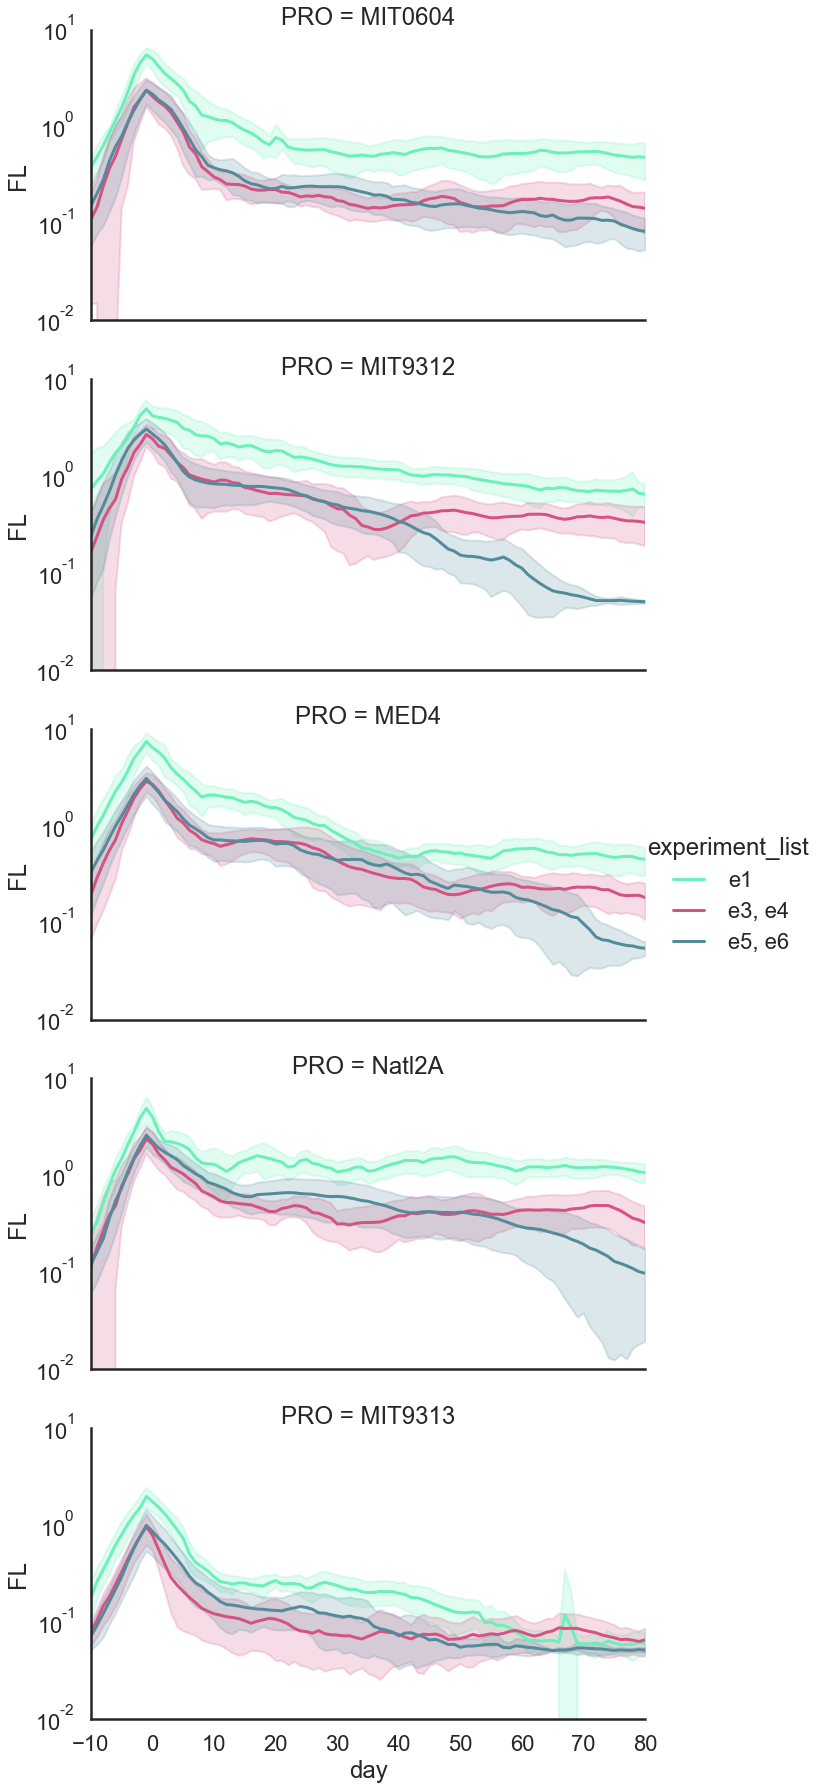

In [19]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', row='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                row_order=porder
               )
g.set(yscale='log')

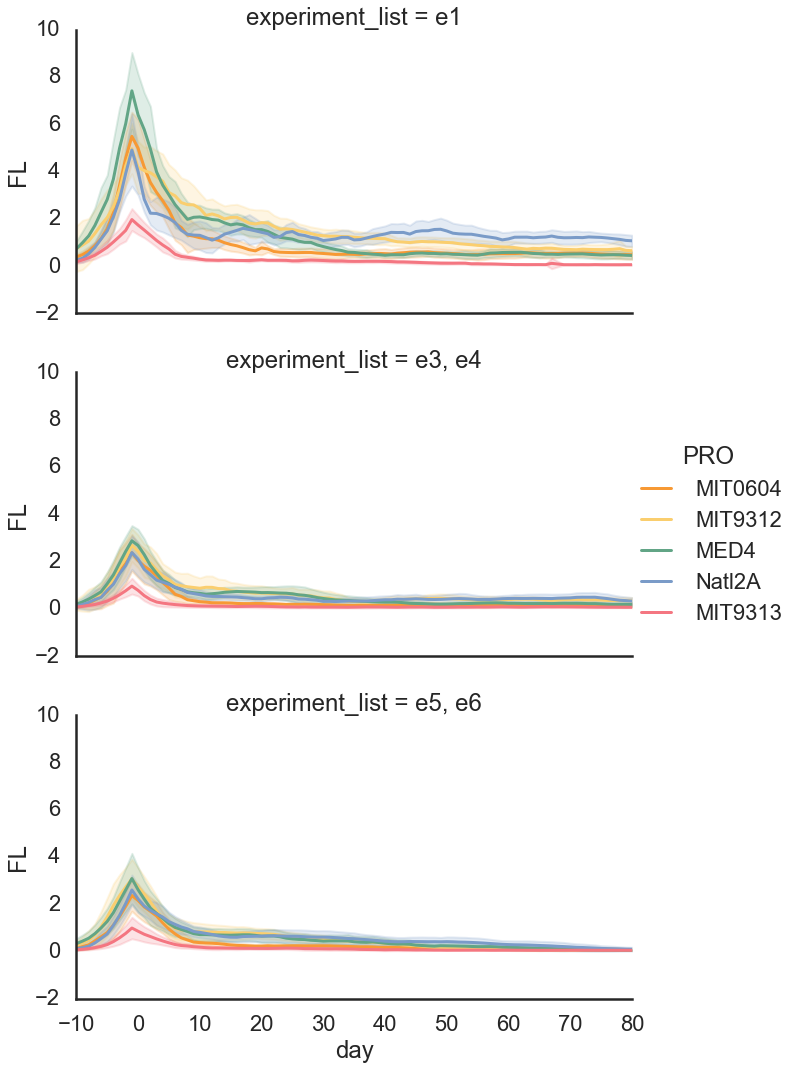

In [20]:
g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
#g.set(yscale='log')

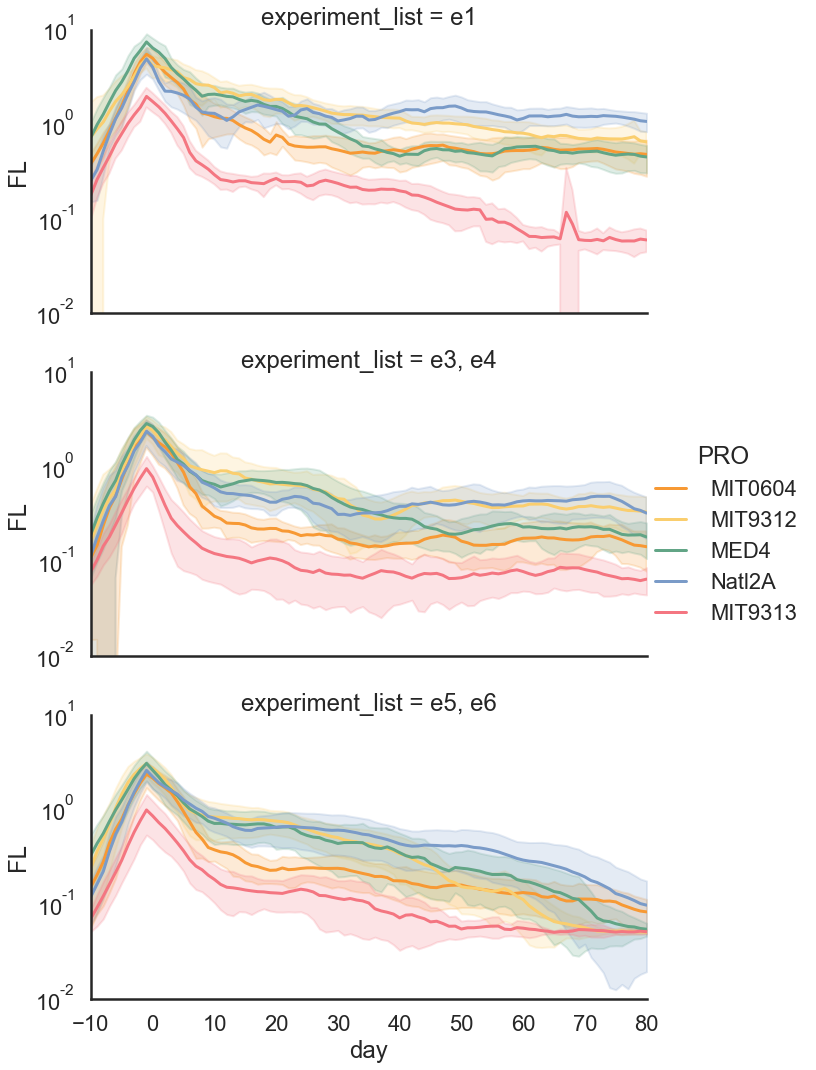

In [21]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
g.set(yscale='log')


In [22]:
ds['decline'] = ds['FL']

In [23]:
ds1 = ds.loc[ds.experiment.isin(['e1'])]
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [24]:
ds34.head()

experiment_sample experiment sample      PRO ALT     culture  day  \
10302           e3, 10A         e3    10A  MIT0604  DE  Co_Culture  -10   
10303           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -9   
10304           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -8   
10305           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -7   
10306           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -6   

          FL experiment_list  decline  
10302  0.299          e3, e4    0.299  
10303  0.381          e3, e4    0.381  
10304  0.693          e3, e4    0.693  
10305  0.959          e3, e4    0.959  
10306  1.225          e3, e4    1.225

# cross validation

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_score
value_col = 'FL'
y_col = 'PRO'
train_df = ds1
test_df = ds34
X_train = cp.experiments2X(ds1, cumsummode=False, value_col=value_col)
X_test = cp.experiments2X(ds34, cumsummode=False, value_col=value_col)
metadf_train = cp.get_meta(train_df)
metadf_test = cp.get_meta(test_df)

metadf_train.index = metadf_train.experiment_sample
metadf_test.index = metadf_test.experiment_sample

y_train = metadf_train[y_col]
y_test = metadf_test[y_col]
#clf = cp.forest_classifier(X=X_train, y=y_train)
scaledX = StandardScaler().fit_transform(X_train)
clf = RandomForestClassifier(n_estimators=100, oob_score=True,
                             )

pro_scores = cross_val_score(clf, scaledX, y_train, cv=10,  )
print("Accuracy: %0.2f (+/- %0.2f)" % (pro_scores.mean(), pro_scores.std() * 2))


Accuracy: 0.92 (+/- 0.19)


In [26]:
pro_scores

array([1.        , 1.        , 0.875     , 0.85714286, 1.        ,
       0.71428571, 1.        , 1.        , 0.85714286, 0.85714286])

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
value_col = 'FL'
y_col = 'ALT'
train_df = ds1
test_df = ds34
X_train = cp.experiments2X(ds1, cumsummode=False, value_col=value_col)
X_test = cp.experiments2X(ds34, cumsummode=False, value_col=value_col)
metadf_train = cp.get_meta(train_df)
metadf_test = cp.get_meta(test_df)

metadf_train.index = metadf_train.experiment_sample
metadf_test.index = metadf_test.experiment_sample

y_train = metadf_train[y_col]
y_test = metadf_test[y_col]
#clf = cp.forest_classifier(X=X_train, y=y_train)
scaledX = StandardScaler().fit_transform(X_train)
clf = RandomForestClassifier(n_estimators=100, oob_score=True,
                             )

alt_scores = cross_val_score(clf, scaledX, y_train, cv=10, )
print("Accuracy: %0.2f (+/- %0.2f)" % (alt_scores.mean(), alt_scores.std() * 2))


Accuracy: 0.62 (+/- 0.52)


In [28]:
alt_scores

array([0.5       , 0.875     , 0.375     , 0.28571429, 0.28571429,
       0.57142857, 0.71428571, 0.57142857, 1.        , 1.        ])

In [29]:
[pro_scores, alt_scores]

[array([1.        , 1.        , 0.875     , 0.85714286, 1.        ,
        0.71428571, 1.        , 1.        , 0.85714286, 0.85714286]),
 array([0.5       , 0.875     , 0.375     , 0.28571429, 0.28571429,
        0.57142857, 0.71428571, 0.57142857, 1.        , 1.        ])]

(0.0, 1.0)

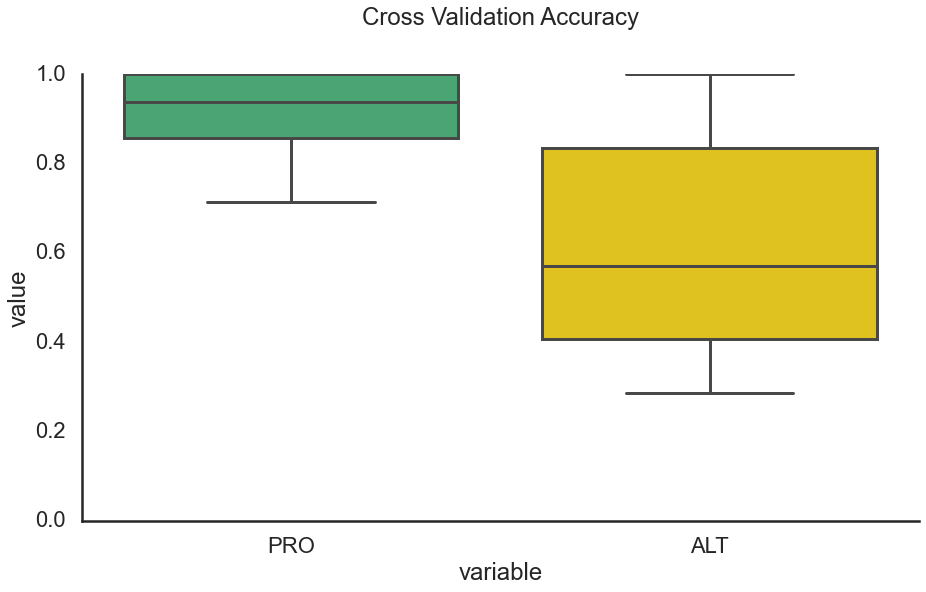

In [30]:
sns.set(style='white', context='poster', #font_scale=1.7
       )
tdf = pd.DataFrame(data=[pro_scores, alt_scores], index=['PRO', 'ALT'])
tdf.T.melt()
sns.boxplot(data=tdf.T.melt(), x='variable', y='value', palette=papallete )
plt.title('Cross Validation Accuracy', y=1.1)
sns.despine()
plt.ylim(0,1)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_score
def compute_cross_val_scores(df, experiment, value_col, y_col):
    train_df = df.loc[df.experiment.isin([experiment])]
    X_train = cp.experiments2X(train_df, cumsummode=False, value_col=value_col)
    metadf_train = cp.get_meta(train_df)
    metadf_train.index = metadf_train.experiment_sample
    y_train = metadf_train[y_col]
    scaledX = StandardScaler().fit_transform(X_train)
    clf = RandomForestClassifier(n_estimators=100, oob_score=True,)
    scores = cross_val_score(clf, scaledX, y_train, cv=10,  )
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return pd.DataFrame({'Accuracy': scores, 'experiment':experiment, 'type':y_col})    


In [32]:
scores_list = [compute_cross_val_scores(ds, e, 'FL', y) for e in eorder for y in ['PRO', 'ALT']]

Accuracy: 0.90 (+/- 0.21)
Accuracy: 0.55 (+/- 0.42)
Accuracy: 0.83 (+/- 0.25)
Accuracy: 0.48 (+/- 0.33)
Accuracy: 0.91 (+/- 0.23)
Accuracy: 0.64 (+/- 0.49)
Accuracy: 0.84 (+/- 0.33)
Accuracy: 0.19 (+/- 0.41)


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.83 (+/- 0.27)


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.42 (+/- 0.56)


In [33]:
scores_df = pd.concat(scores_list)

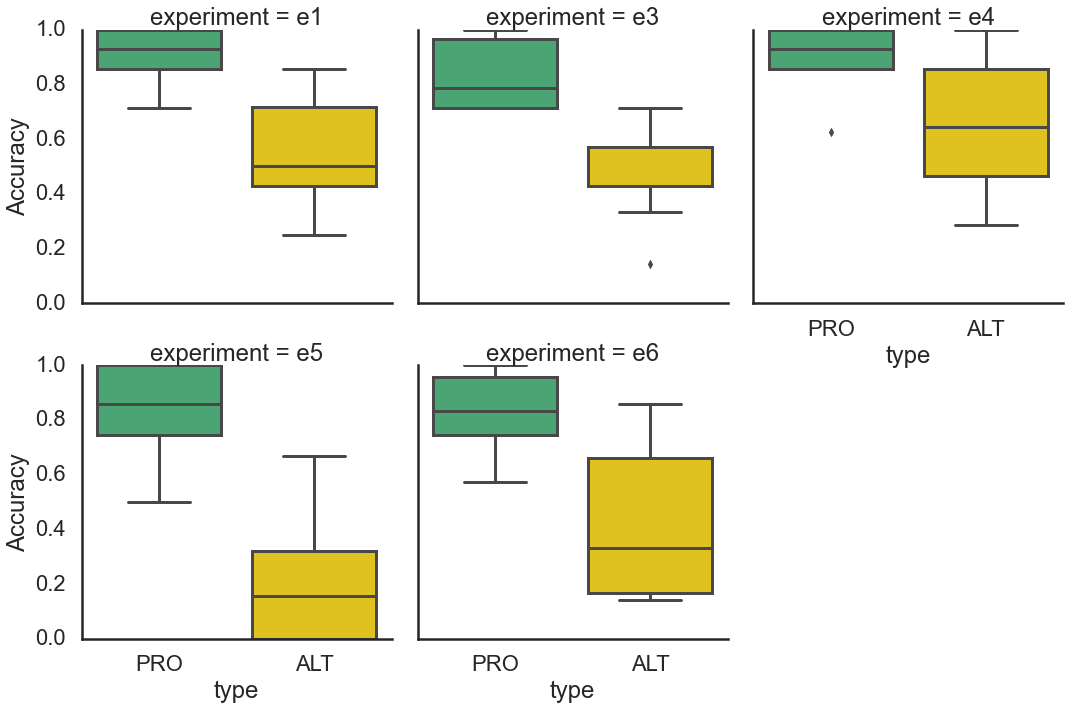

In [34]:
sns.set_context('poster')
sns.catplot(data=scores_df, x='type', col='experiment', y='Accuracy', col_wrap=3, 
            col_order=eorder, kind='box', order=paorder, palette=papallete)

Text(0.5, 1.0, 'Cross Validation Accuracy')

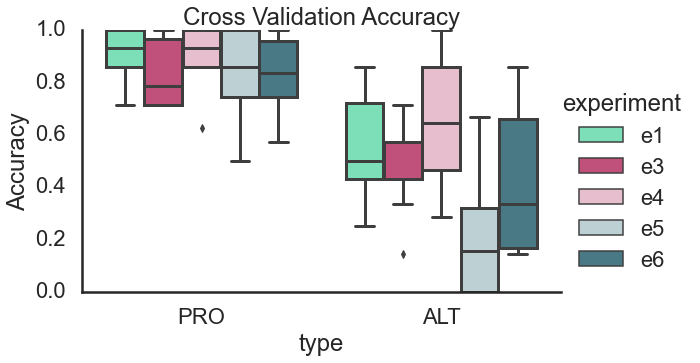

In [35]:
sns.set_context('poster')
sns.catplot(data=scores_df, x='type', hue='experiment', y='Accuracy', hue_order=eorder, 
            kind='box', palette=epallete, aspect=1.6)
plt.title('Cross Validation Accuracy')

Text(0.5, 1.0, 'Cross Validation Accuracy')

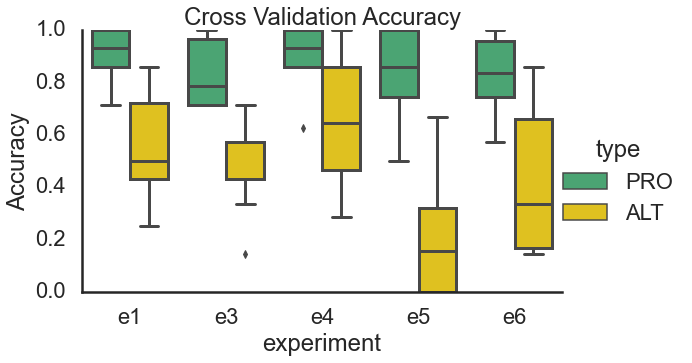

In [36]:
sns.set_context('poster')
sns.catplot(data=scores_df, hue='type', x='experiment', y='Accuracy', order=eorder, 
            kind='box', hue_order=paorder, palette=papallete, aspect=1.6)
plt.title('Cross Validation Accuracy')

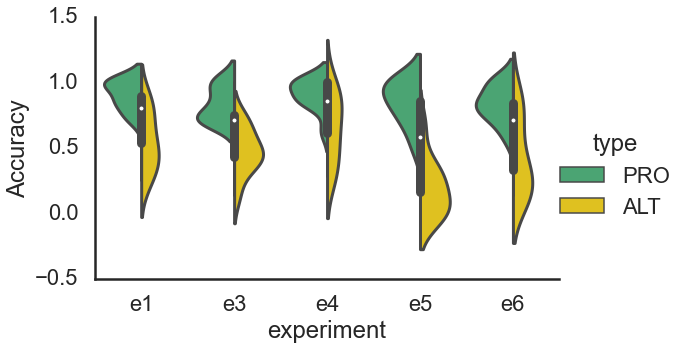

In [37]:
sns.set_context('poster')
sns.catplot(data=scores_df, hue='type', x='experiment', y='Accuracy', order=eorder, 
            kind='violin', split=True, hue_order=paorder, palette=papallete, aspect=1.6)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
value_col = 'FL'
y_col = 'ALT'
train_df = ds1
test_df = ds34
X_train = cp.experiments2X(ds1, cumsummode=False, value_col=value_col)
X_test = cp.experiments2X(ds34, cumsummode=False, value_col=value_col)
metadf_train = cp.get_meta(train_df)
metadf_test = cp.get_meta(test_df)

metadf_train.index = metadf_train.experiment_sample
metadf_test.index = metadf_test.experiment_sample

y_train = metadf_train[y_col]
y_test = metadf_test[y_col]
#clf = cp.forest_classifier(X=X_train, y=y_train)
scaledX = StandardScaler().fit_transform(X_train)
clf = RandomForestClassifier(n_estimators=100, oob_score=True,
                             )

alt_scores = cross_val_score(clf, scaledX, y_train, cv=10, )
print("Accuracy: %0.2f (+/- %0.2f)" % (alt_scores.mean(), alt_scores.std() * 2))


Accuracy: 0.60 (+/- 0.55)


In [39]:
alt_scores

array([0.625     , 0.875     , 0.375     , 0.14285714, 0.28571429,
       0.57142857, 0.57142857, 0.57142857, 1.        , 1.        ])

(0.0, 1.0)

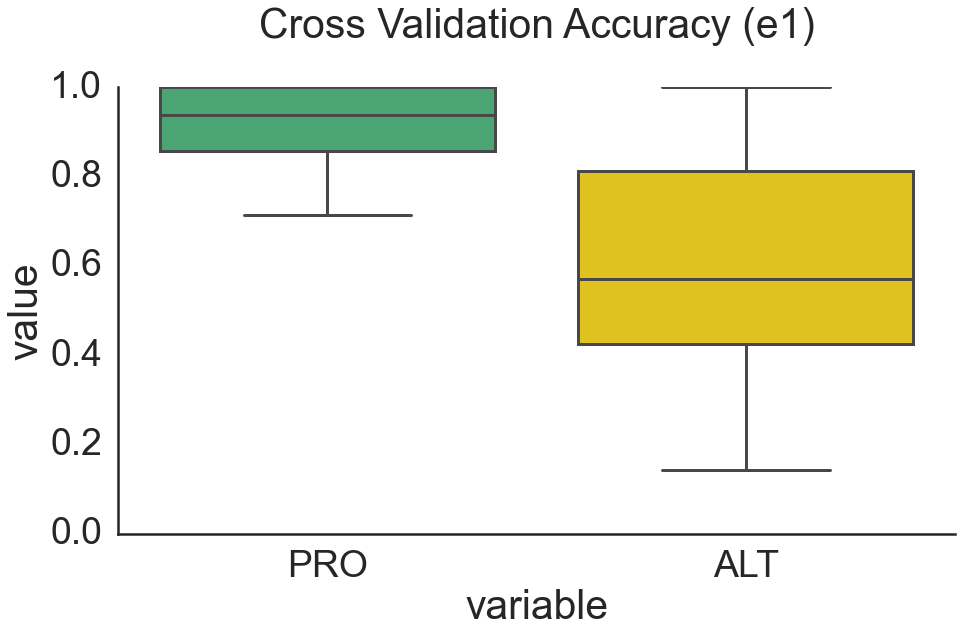

In [40]:
sns.set(style='white', context='poster', font_scale=1.7)
tdf = pd.DataFrame(data=[pro_scores, alt_scores], index=['PRO', 'ALT'])
tdf.T.melt()
sns.boxplot(data=tdf.T.melt(), x='variable', y='value', palette=papallete )
plt.title('Cross Validation Accuracy (e1)', y=1.1)
sns.despine()
plt.ylim(0,1)

In [41]:
sns.set(style='white', context='poster', font_scale=1.7)
pslist = [f'test_f1_{p}' for p in porder]
#[pro_scores[i] for i in pslist]
pro_scores
#tdf = pd.DataFrame(data=[pro_scores[i] for i in pslist], index=pslist)
# tdf.T.melt()
# sns.boxplot(data=tdf.T.melt(), x='variable', y='value', palette=papallete )

# plt.title('Cross Validation F1 macro', y=1.1)
# sns.despine()
# plt.ylim(0,1)

array([1.        , 1.        , 0.875     , 0.85714286, 1.        ,
       0.71428571, 1.        , 1.        , 0.85714286, 0.85714286])

In [42]:
res, _y_list, _clf_list, _features_list = cp.compare_models2(ds34, ds56, 
               value_col_list=['FL'], 
               y_col_list=['PRO', 'ALT'], 
               repetitions=30,
               return_y=True)


PRO_FL
train score 1.0
oob score 0.8794326241134752
train score 1.0
oob score 0.8439716312056738
train score 1.0
oob score 0.8439716312056738


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.8865248226950354
train score 1.0
oob score 0.8865248226950354
train score 1.0
oob score 0.851063829787234
train score 1.0
oob score 0.8439716312056738
train score 1.0
oob score 0.8723404255319149
train score 1.0
oob score 0.8723404255319149
train score 1.0
oob score 0.8439716312056738
train score 1.0
oob score 0.8297872340425532


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.8723404255319149
train score 1.0
oob score 0.8652482269503546
train score 1.0
oob score 0.851063829787234
train score 1.0
oob score 0.8368794326241135


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.8439716312056738
train score 1.0
oob score 0.8723404255319149
train score 1.0
oob score 0.8794326241134752
train score 1.0
oob score 0.8723404255319149
train score 1.0
oob score 0.851063829787234
train score 1.0
oob score 0.8794326241134752
train score 1.0
oob score 0.851063829787234
train score 1.0
oob score 0.8723404255319149
train score 1.0
oob score 0.8936170212765957


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.851063829787234
train score 1.0
oob score 0.8936170212765957
train score 1.0
oob score 0.8652482269503546
train score 1.0
oob score 0.8652482269503546
train score 1.0
oob score 0.8297872340425532
train score 1.0
oob score 0.8581560283687943
ALT_FL
train score 1.0
oob score 0.5390070921985816
train score 1.0
oob score 0.5531914893617021


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5602836879432624


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5460992907801419


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.48936170212765956
train score 1.0
oob score 0.5390070921985816


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5602836879432624
train score 1.0
oob score 0.574468085106383


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5957446808510638


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.574468085106383
train score 1.0
oob score 0.5319148936170213
train score 1.0
oob score 0.5460992907801419
train score 1.0
oob score 0.574468085106383


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5106382978723404


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5460992907801419
train score 1.0
oob score 0.5815602836879432
train score 1.0
oob score 0.5815602836879432


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5531914893617021


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.524822695035461
train score 1.0
oob score 0.5460992907801419


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.574468085106383


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5106382978723404


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5602836879432624


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5390070921985816


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5460992907801419


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5673758865248227


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5460992907801419


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5602836879432624


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5319148936170213


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score 1.0
oob score 0.5673758865248227


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
stats1to34_df = pd.DataFrame.from_records(res)


In [44]:
stats1to34_df.nlargest(5,'f1_test')

model  n_features  orig_n_features  accuracy_train  precision_train  \
25  PRO_FL          91               91             1.0              1.0   
5   PRO_FL          91               91             1.0              1.0   
27  PRO_FL          91               91             1.0              1.0   
20  PRO_FL          91               91             1.0              1.0   
6   PRO_FL          91               91             1.0              1.0   

    recall_train  f1_train support_train  accuracy_test  precision_test  \
25           1.0       1.0          None       0.503876        0.624142   
5            1.0       1.0          None       0.496124        0.632724   
27           1.0       1.0          None       0.496124        0.628825   
20           1.0       1.0          None       0.488372        0.622199   
6            1.0       1.0          None       0.488372        0.619852   

    recall_test   f1_test support_test value_col y_col  
25     0.503876  0.438539         None        FL   PRO  
5      0.496124  0.435790         None        FL   PRO  
27     0.496124  0.434884         None        FL   PRO  
20     0.488372  0.428198         None        FL   PRO  
6      0.488372  0.425549         None        FL   PRO

In [45]:
stats1to34_df.loc[stats1to34_df.y_col == 'PRO']. nlargest(5,'f1_test')

model  n_features  orig_n_features  accuracy_train  precision_train  \
25  PRO_FL          91               91             1.0              1.0   
5   PRO_FL          91               91             1.0              1.0   
27  PRO_FL          91               91             1.0              1.0   
20  PRO_FL          91               91             1.0              1.0   
6   PRO_FL          91               91             1.0              1.0   

    recall_train  f1_train support_train  accuracy_test  precision_test  \
25           1.0       1.0          None       0.503876        0.624142   
5            1.0       1.0          None       0.496124        0.632724   
27           1.0       1.0          None       0.496124        0.628825   
20           1.0       1.0          None       0.488372        0.622199   
6            1.0       1.0          None       0.488372        0.619852   

    recall_test   f1_test support_test value_col y_col  
25     0.503876  0.438539         None        FL   PRO  
5      0.496124  0.435790         None        FL   PRO  
27     0.496124  0.434884         None        FL   PRO  
20     0.488372  0.428198         None        FL   PRO  
6      0.488372  0.425549         None        FL   PRO

In [46]:
stats1to34_df.loc[stats1to34_df.y_col == 'ALT']. nlargest(5,'f1_test')

model  n_features  orig_n_features  accuracy_train  precision_train  \
44  ALT_FL          91               91             1.0              1.0   
47  ALT_FL          91               91             1.0              1.0   
49  ALT_FL          91               91             1.0              1.0   
56  ALT_FL          91               91             1.0              1.0   
40  ALT_FL          91               91             1.0              1.0   

    recall_train  f1_train support_train  accuracy_test  precision_test  \
44           1.0       1.0          None       0.286822        0.284750   
47           1.0       1.0          None       0.294574        0.325618   
49           1.0       1.0          None       0.279070        0.246873   
56           1.0       1.0          None       0.271318        0.260539   
40           1.0       1.0          None       0.279070        0.276975   

    recall_test   f1_test support_test value_col y_col  
44     0.286822  0.263525         None        FL   ALT  
47     0.294574  0.262648         None        FL   ALT  
49     0.279070  0.252042         None        FL   ALT  
56     0.271318  0.250567         None        FL   ALT  
40     0.279070  0.250067         None        FL   ALT

In [48]:
train1_df_orig, test1_df_orig = cp.split_train_test(ds1,test_size=0.4, y_col='PRO')
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [49]:
test1_df_orig.groupby(['PRO', 'ALT'])['sample'].unique()

PRO      ALT 
MED4     1A3            [1A, 1B]
         ATCC         [21A, 21C]
         DE                 [6B]
         DE1               [11A]
MIT0604  1A3                [5B]
         ATCC              [25C]
         BS11         [20A, 20C]
         DE1          [15B, 15C]
MIT9312  1A3            [3A, 3C]
         ATCC              [23B]
         DE                 [8A]
         DE1          [13B, 13C]
MIT9313  ATCC              [22B]
         BS11              [17A]
         DE             [7A, 7C]
         DE1          [12A, 12B]
Natl2A   ATCC    [24A, 24B, 24C]
         BS11              [19A]
         DE                 [9A]
         DE1               [14C]
Name: sample, dtype: object

In [50]:
train1_df = train1_df_orig
test1_df = test1_df_orig
train34_df = train34_df_orig
test34_df = test34_df_orig
train56_df = train56_df_orig
test56_df = test56_df_orig

In [51]:
train1_df.shape, test1_df.shape, train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

((3913, 10), (2730, 10), (7644, 10), (5187, 10), (6818, 10), (4573, 10))

In [52]:
train34_df.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'day', 'FL', 'experiment_list', 'decline'],
      dtype='object')

In [53]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 0.7976190476190477
train score 1.0
oob score 0.7619047619047619
train score 1.0
oob score 0.7857142857142857
train score 1.0
oob score 0.7857142857142857
train score 1.0
oob score 0.7619047619047619
train score 1.0
oob score 0.8214285714285714
train score 1.0
oob score 0.7619047619047619
train score 1.0
oob score 0.8095238095238095
train score 1.0
oob score 0.8095238095238095
train score 1.0
oob score 0.8214285714285714
train score 1.0
oob score 0.7738095238095238
train score 1.0
oob score 0.7619047619047619
train score 1.0
oob score 0.7738095238095238
train score 1.0
oob score 0.7738095238095238
train score 1.0
oob score 0.7857142857142857
train score 1.0
oob score 0.7976190476190477
train score 1.0
oob score 0.7619047619047619
train score 1.0
oob score 0.7976190476190477
train score 1.0
oob score 0.8095238095238095
train score 1.0
oob score 0.7738095238095238
train score 1.0
oob score 0.7619047619047619
train score 1.0
oob score 0.7619047619047619
tra

In [54]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 0.7532467532467533
train score 1.0
oob score 0.7402597402597403
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7662337662337663
train score 1.0
oob score 0.7142857142857143
train score 1.0
oob score 0.7532467532467533
train score 1.0
oob score 0.7142857142857143
train score 1.0
oob score 0.6753246753246753
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7142857142857143
train score 1.0
oob score 0.7662337662337663
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7142857142857143
train score 1.0
oob score 0.7532467532467533
train score 1.0
oob score 0.7272727272727273
train score 1.0
oob score 0.7662337662337663
train score 1.0
oob score 0.7272727272727273
train score 1.0
oob score 0.7012987012987013
train score 1.0
oob score 0.7272727272727273
tra

In [55]:
stats1_list = []
y1_list = []
clf1_list = []
features1_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train1_df, test1_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats1_list.extend(res)
y1_list.extend(_y_list)
clf1_list.extend(_clf_list)
features1_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 0.7906976744186046
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.7906976744186046
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.7906976744186046
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.7906976744186046
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.7906976744186046
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.8604651162790697
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.8372093023255814
train score 1.0
oob score 0.813953488372093
train score 1.0
oob score 0.8372093023255814
train sco

In [56]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)
stats1_df = pd.DataFrame.from_records(stats1_list)


In [57]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
13  0.843866       0.846154             1.0
24  0.824798       0.826923             1.0
3   0.822172       0.826923             1.0
27  0.822072       0.826923             1.0
12  0.805895       0.807692             1.0
0   0.803205       0.807692             1.0
25  0.798544       0.807692             1.0
11  0.786827       0.788462             1.0
26  0.785431       0.788462             1.0
29  0.785431       0.788462             1.0

In [58]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
3   0.946667       0.947368             1.0
12  0.929691       0.929825             1.0
26  0.929691       0.929825             1.0
8   0.929141       0.929825             1.0
13  0.910725       0.912281             1.0
16  0.894491       0.894737             1.0
15  0.894385       0.894737             1.0
23  0.894385       0.894737             1.0
20  0.894385       0.894737             1.0
11  0.893655       0.894737             1.0

In [59]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
15      1.0            1.0             1.0
10      1.0            1.0             1.0
28      1.0            1.0             1.0
27      1.0            1.0             1.0
26      1.0            1.0             1.0
23      1.0            1.0             1.0
18      1.0            1.0             1.0
17      1.0            1.0             1.0
11      1.0            1.0             1.0
29      1.0            1.0             1.0

In [60]:
idx34 = 25
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [61]:
y34_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred PRO_FL_y_pred_PRO   Type
experiment_sample                                                             
e3, 10B            MIT0604      MIT0604       MIT0604           MIT0604  Train
e3, 10C            MIT0604      MIT0604       MIT0604           MIT0604  Train
e3, 11C               MED4         MED4          MED4              MED4  Train
e3, 12A            MIT9313      MIT9313       MIT9313           MIT9313  Train
e3, 12B            MIT9313      MIT9313       MIT9313           MIT9313  Train

accuracy: 0.8947368421052632
              precision    recall  f1-score   support

        MED4       0.92      0.92      0.92        12
     MIT0604       0.83      1.00      0.91        10
     MIT9312       0.91      0.83      0.87        12
     MIT9313       1.00      1.00      1.00        10
      Natl2A       0.83      0.77      0.80        13

    accuracy                           0.89        57
   macro avg       0.90      0.90      0.90        57
weighted avg       0.90      0.89      0.89        57



Text(0.5, 1.0, 'e3, e4, accuracy=0.89')

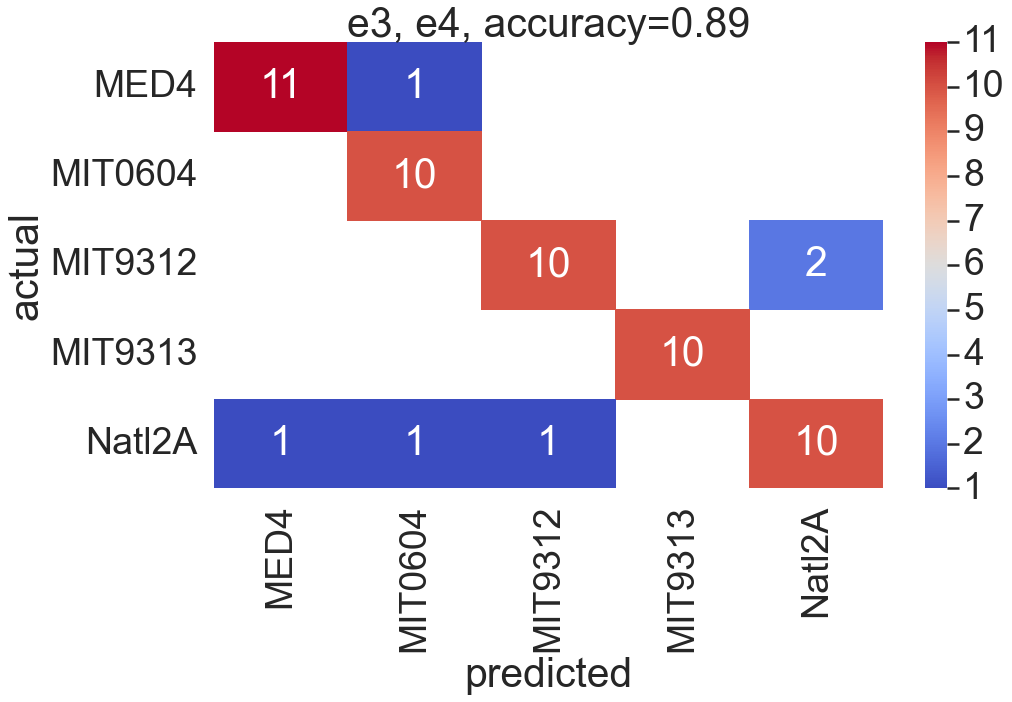

In [62]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')
    plt.title(f"e3, e4, accuracy={accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']):.2}")

Text(0.5, 1.0, 'e3 ,e4')

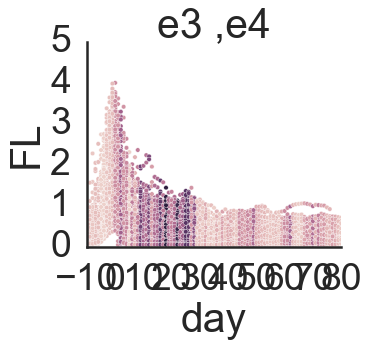

In [63]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)
plt.ylim(0,5)
plt.xlim(-10,80)
plt.title('e3 ,e4')

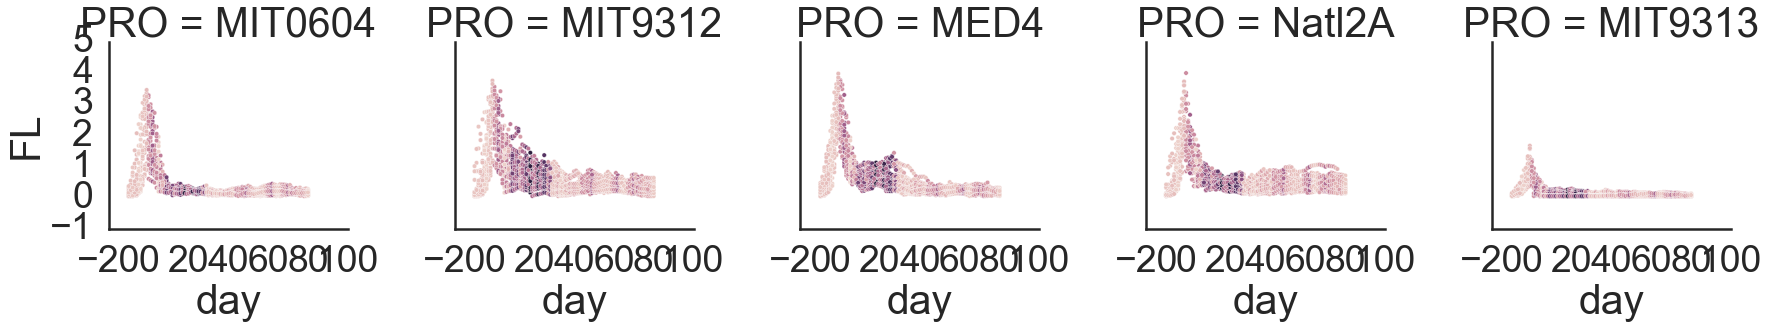

In [64]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

<AxesSubplot:ylabel='day'>

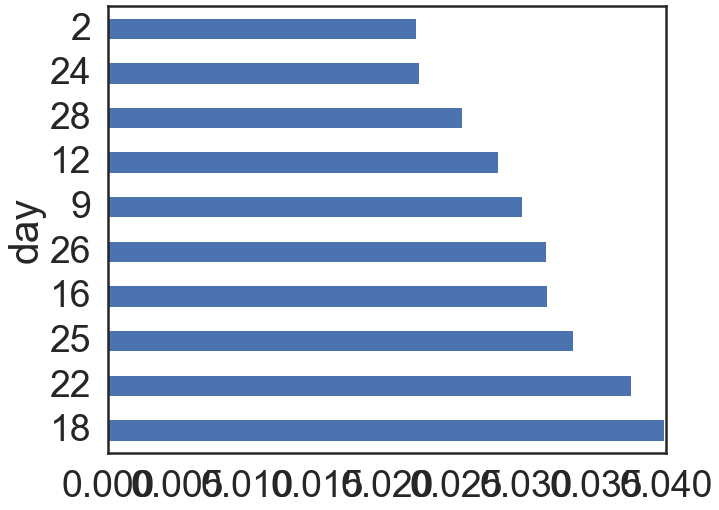

In [65]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [66]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
13  0.843866       0.846154             1.0
24  0.824798       0.826923             1.0
3   0.822172       0.826923             1.0
27  0.822072       0.826923             1.0
12  0.805895       0.807692             1.0
0   0.803205       0.807692             1.0
25  0.798544       0.807692             1.0
11  0.786827       0.788462             1.0
26  0.785431       0.788462             1.0
29  0.785431       0.788462             1.0

In [67]:
idx56 = 8
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [68]:
y56_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred PRO_FL_y_pred_PRO   Type
experiment_sample                                                             
e5, 10A            MIT0604      MIT0604       MIT0604           MIT0604  Train
e5, 11A               MED4         MED4          MED4              MED4  Train
e5, 11C               MED4         MED4          MED4              MED4  Train
e5, 12A            MIT9313      MIT9313       MIT9313           MIT9313  Train
e5, 12B            MIT9313      MIT9313       MIT9313           MIT9313  Train

accuracy: 0.7884615384615384
              precision    recall  f1-score   support

        MED4       0.67      0.60      0.63        10
     MIT0604       0.82      0.82      0.82        11
     MIT9312       0.82      0.75      0.78        12
     MIT9313       0.82      1.00      0.90         9
      Natl2A       0.80      0.80      0.80        10

    accuracy                           0.79        52
   macro avg       0.78      0.79      0.79        52
weighted avg       0.79      0.79      0.78        52



Text(0.5, 1.0, 'e5, e6, accuracy=0.79')

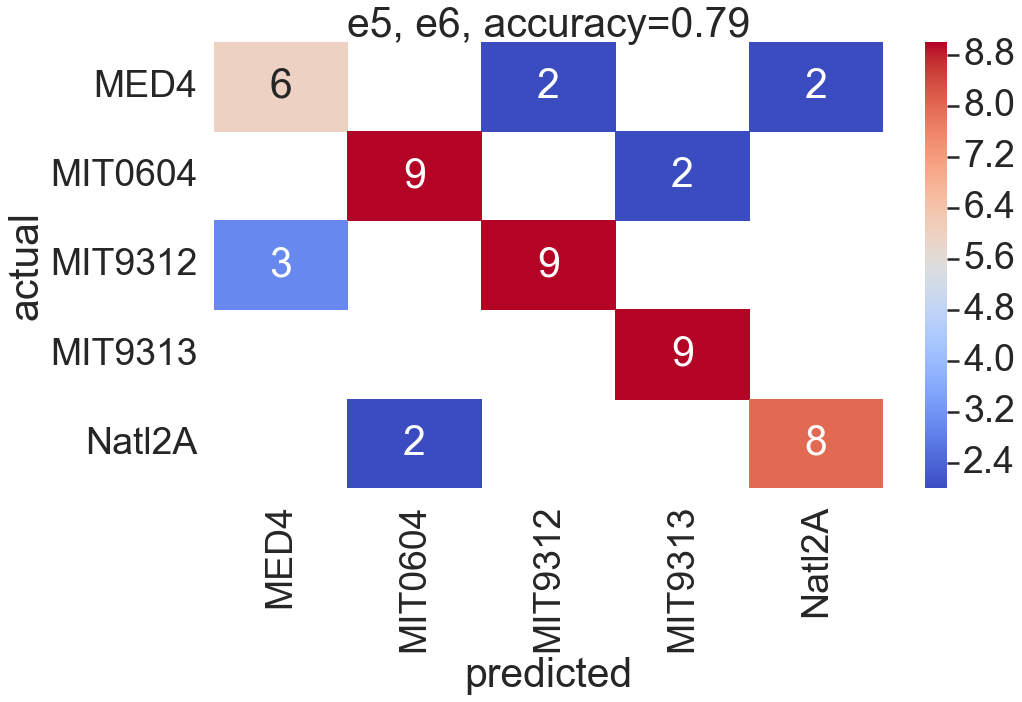

In [69]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')
    plt.title(f"e5, e6, accuracy={accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']):.2}")

Text(0.5, 1.0, 'e5, e6')

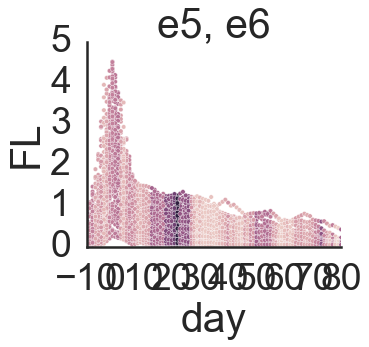

In [70]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)
plt.ylim(0,5)
plt.xlim(-10,80)

plt.title('e5, e6')

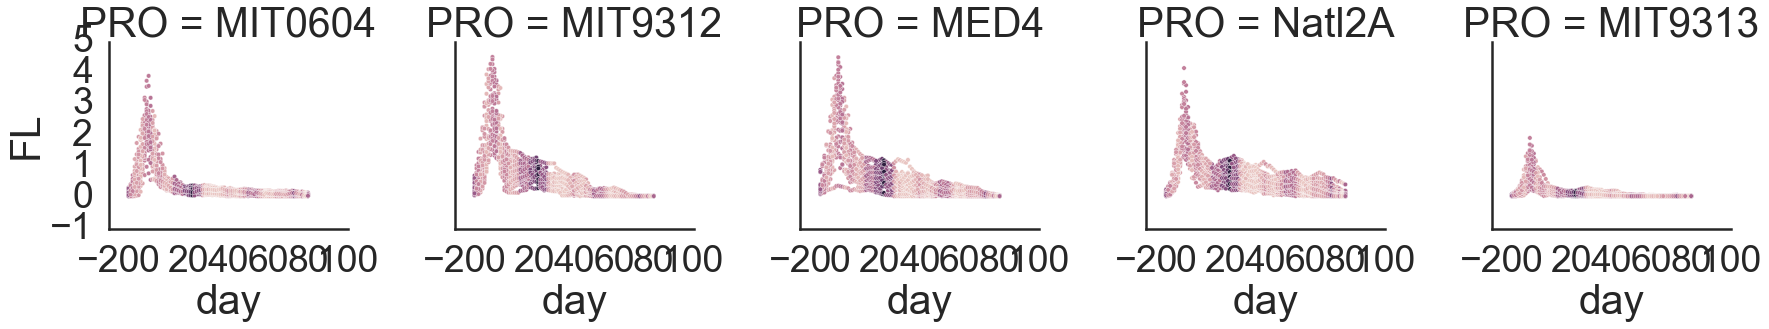

In [71]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

<AxesSubplot:ylabel='day'>

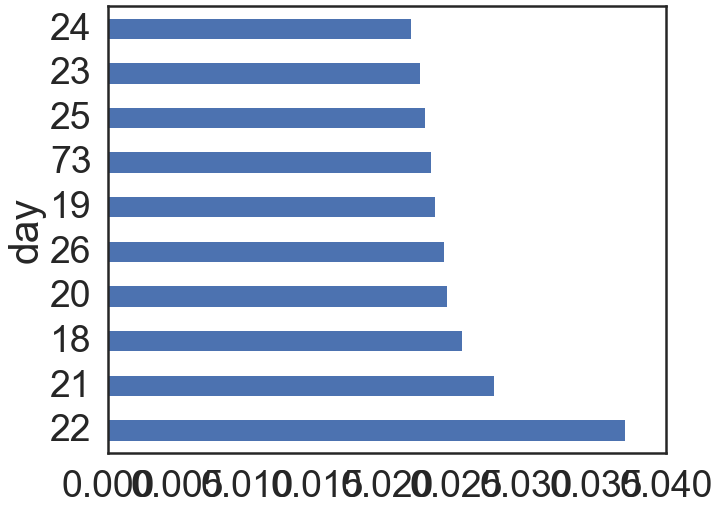

In [72]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [73]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
15      1.0            1.0             1.0
10      1.0            1.0             1.0
28      1.0            1.0             1.0
27      1.0            1.0             1.0
26      1.0            1.0             1.0
23      1.0            1.0             1.0
18      1.0            1.0             1.0
17      1.0            1.0             1.0
11      1.0            1.0             1.0
29      1.0            1.0             1.0

In [74]:
idx1 = 25
y1_df =  y1_list[idx1]
clf1 = clf1_list[idx1]
features1 = features1_list[idx1]

In [75]:
y1_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred PRO_FL_y_pred_PRO   Type
experiment_sample                                                             
e1, 10A            MIT0604      MIT0604       MIT0604           MIT0604  Train
e1, 10B            MIT0604      MIT0604       MIT0604           MIT0604  Train
e1, 10C            MIT0604      MIT0604       MIT0604           MIT0604  Train
e1, 11B               MED4         MED4          MED4              MED4  Train
e1, 11C               MED4         MED4          MED4              MED4  Train

accuracy: 0.9333333333333333
              precision    recall  f1-score   support

        MED4       1.00      1.00      1.00         6
     MIT0604       1.00      0.83      0.91         6
     MIT9312       0.75      1.00      0.86         6
     MIT9313       1.00      1.00      1.00         6
      Natl2A       1.00      0.83      0.91         6

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.94        30
weighted avg       0.95      0.93      0.94        30



Text(0.5, 1.0, 'e1, accuracy=0.93')

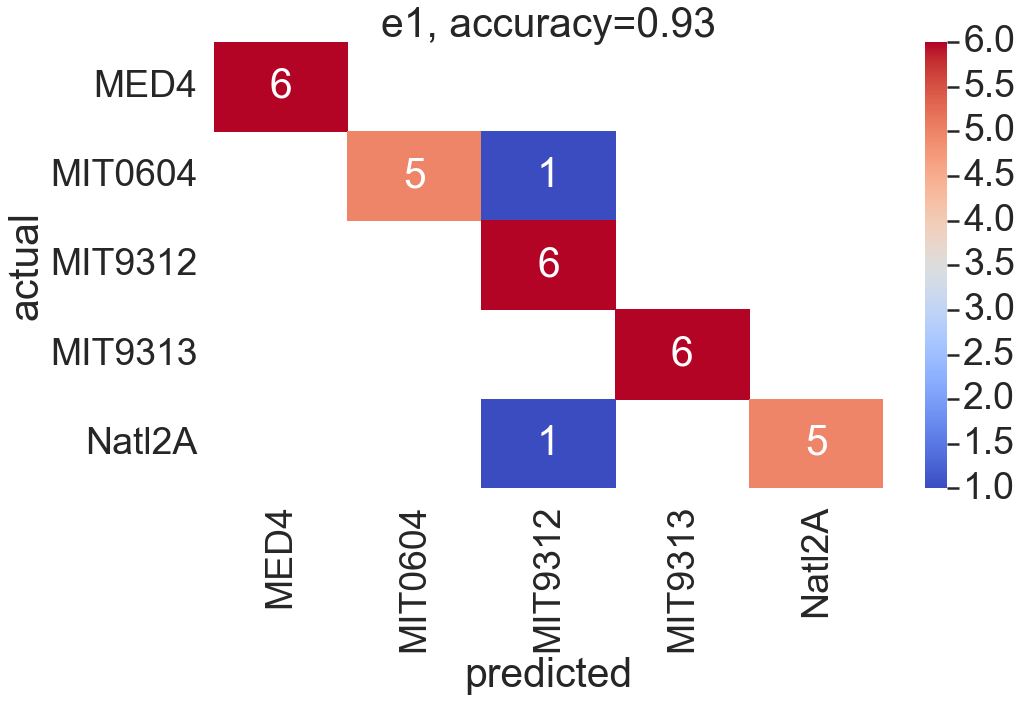

In [76]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y1_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')
    plt.title(f"e1, accuracy={accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']):.2}")

Text(0.5, 1.0, 'e1')

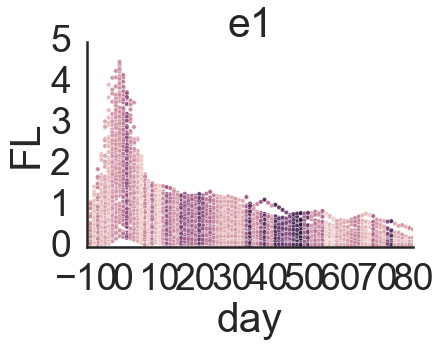

In [77]:
feature_importances1 = pd.DataFrame(clf1.feature_importances_,
                                   index = features1,
                                    columns=['importance'])
merge1df = ds56.merge(feature_importances1, left_on='day', right_index=True, how='left')
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, aspect=1.4)
plt.ylim(0,5)
plt.xlim(-10,80)
plt.title('e1')
#plt.title('FL per day (experiment 1) - colored by impotance')

Text(0.5, 1.0, 'FL per day (experiment 1) - sized by impotance')

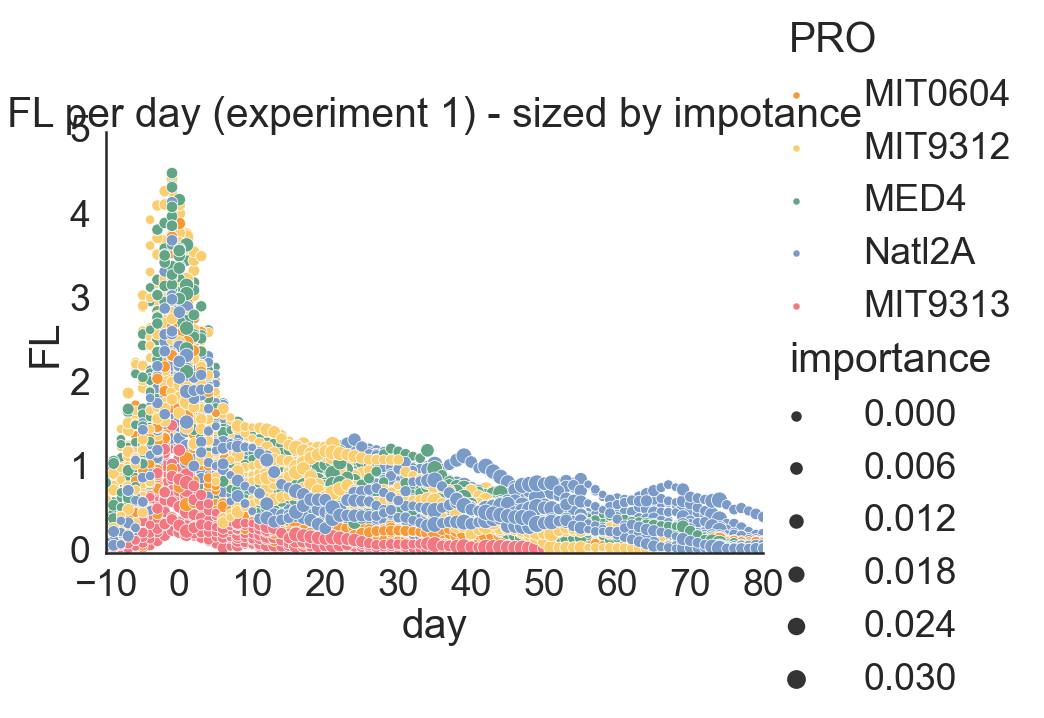

In [78]:
feature_importances1 = pd.DataFrame(clf1.feature_importances_,
                                   index = features1,
                                    columns=['importance'])
merge1df = ds56.merge(feature_importances1, left_on='day', right_index=True, how='left')
sns.relplot(data=merge1df, x='day', y='FL', size='importance', hue='PRO', 
            aspect=1.4, height=8,
            hue_order=porder, palette=ppallete,
           )
plt.ylim(0,5)
plt.xlim(-10,80)
plt.title('FL per day (experiment 1) - sized by impotance')

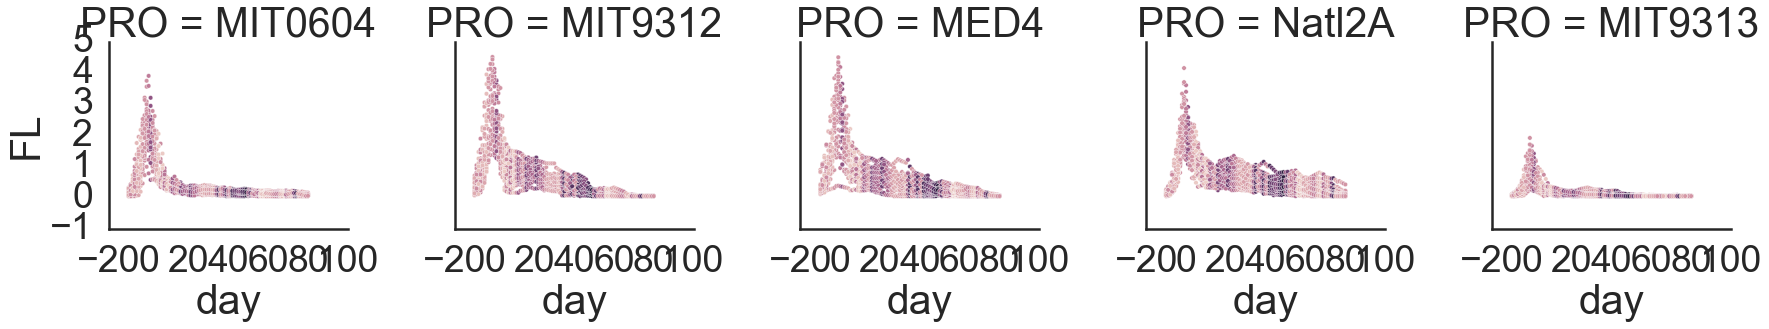

In [79]:
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

<AxesSubplot:ylabel='day'>

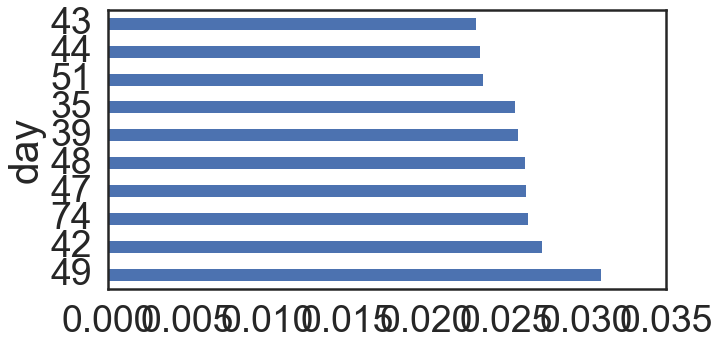

In [80]:
feature_importances1.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,5) )

In [81]:
feature_importances_all34 = pd.DataFrame({
    'day': [v for l in features34_list for v in l],
    'importance' :  [v for l in clf34_list for v in l.feature_importances_ ]
})
feature_importances_all56 = pd.DataFrame({
    'day': [v for l in features56_list for v in l],
    'importance' :  [v for l in clf56_list for v in l.feature_importances_ ]
})
feature_importances_all1 = pd.DataFrame({
    'day': [v for l in features1_list for v in l],
    'importance' :  [v for l in clf1_list for v in l.feature_importances_ ]
})



In [82]:
feature_importances_all34.index

RangeIndex(start=0, stop=2730, step=1)

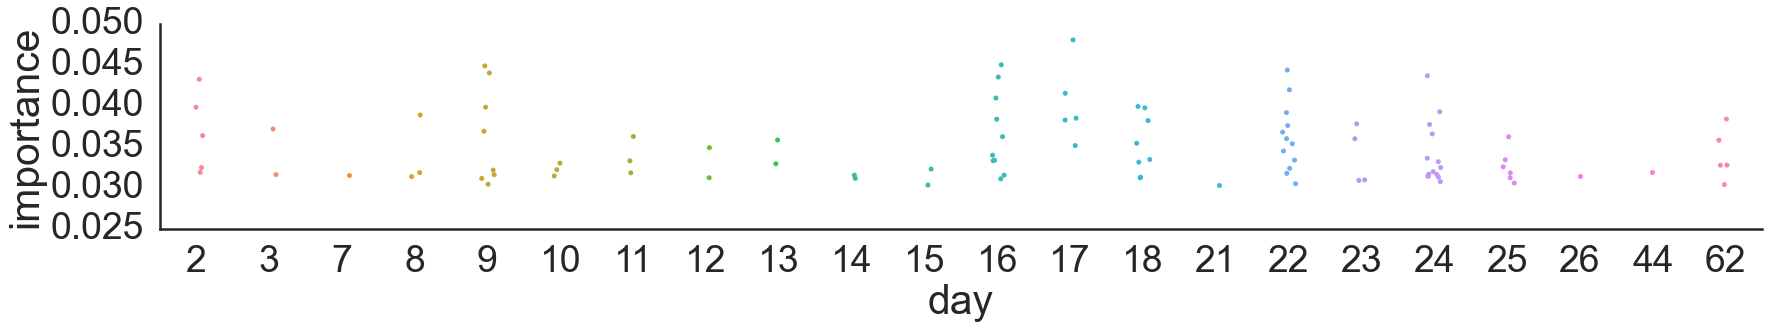

In [83]:
sns.catplot(data=feature_importances_all34.nlargest(columns='importance', n=100), x='day', y='importance',  aspect=5)

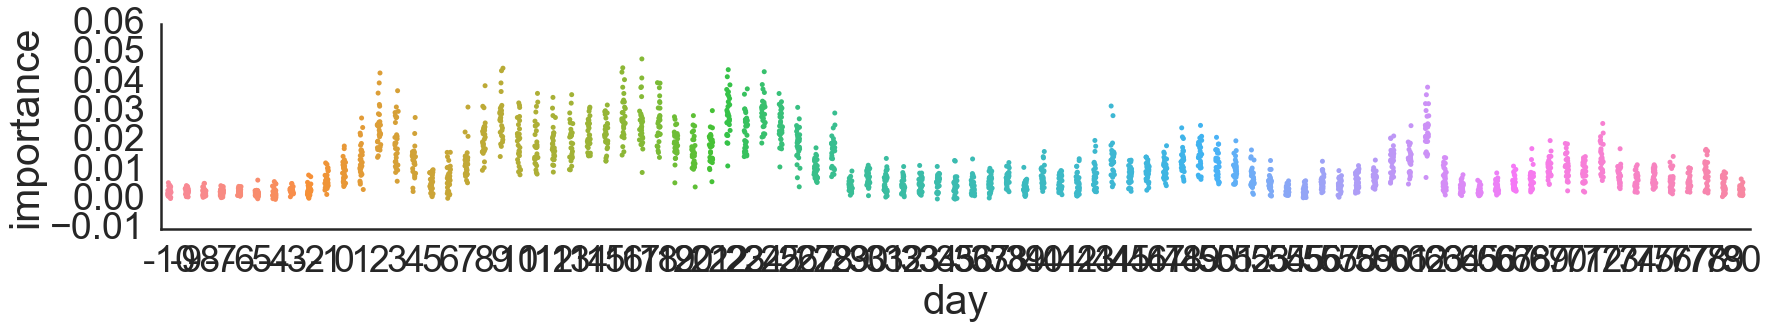

In [84]:
sns.catplot(data=feature_importances_all34, x='day', y='importance',  aspect=5)

Text(0.5, 1.0, 'importance per day')

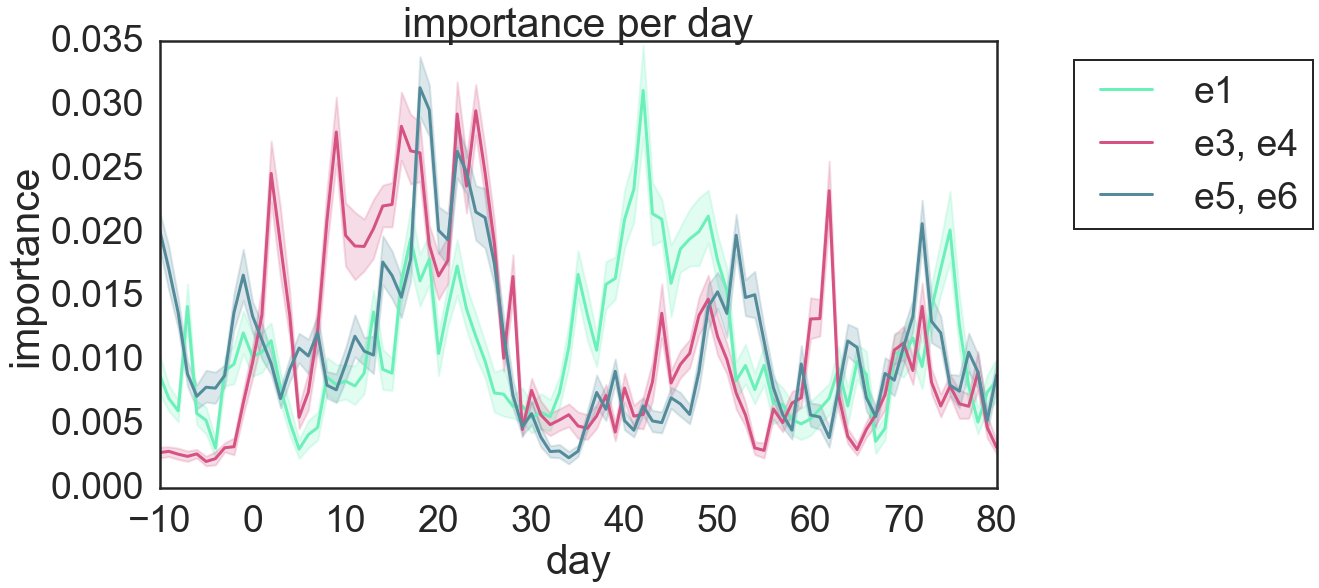

In [85]:
sns.lineplot(data=feature_importances_all1, x='day', y='importance', color=espallete[0],   label='e1', )
sns.lineplot(data=feature_importances_all34, x='day', y='importance', color=espallete[1], label='e3, e4')
sns.lineplot(data=feature_importances_all56, x='day', y='importance', color=espallete[2],  label='e5, e6')
plt.legend(bbox_to_anchor=(1.4,1))
plt.title('importance per day')

In [86]:
feature_importances_all1['experiment'] = 'e1'
feature_importances_all34['experiment'] = 'e3, e4'
feature_importances_all56['experiment'] = 'e5, e6'

feature_importances_all_combined = pd.concat([feature_importances_all1, 
                                              feature_importances_all34, feature_importances_all56])



In [87]:
feature_importances_all_combined.head()

day  importance experiment
0  -10    0.015705         e1
1   -9    0.009795         e1
2   -8    0.007634         e1
3   -7    0.011599         e1
4   -6    0.006258         e1

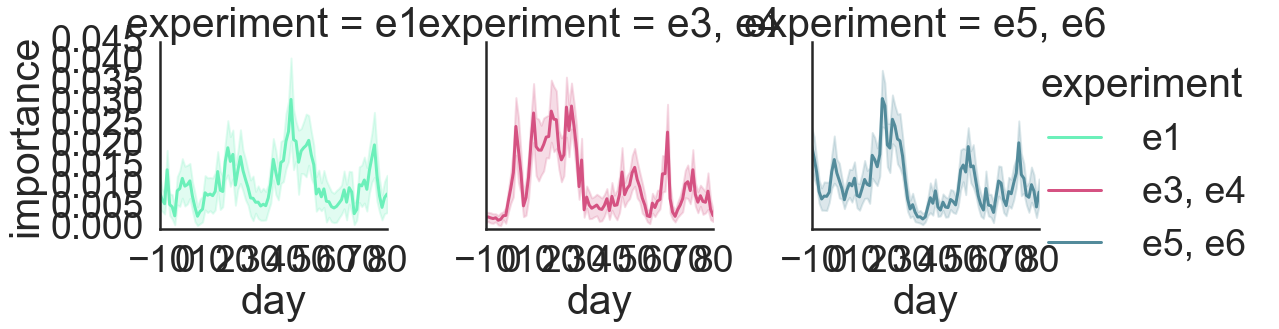

In [88]:
g = sns.relplot(data=feature_importances_all_combined, ci='sd', 
                hue='experiment', palette=espallete,
           y='importance', x='day', col='experiment', kind='line')
#g = sns.relplot(data=feature_importances_all_combined, 
#           y='importance', x='day', col='experiment', ax=g)


In [89]:
all1_days = feature_importances_all1.groupby(['day']).mean().nlargest(10, 'importance').index
all34_days = feature_importances_all34.groupby(['day']).mean().nlargest(10, 'importance').index
all56_days = feature_importances_all56.groupby(['day']).mean().nlargest(10, 'importance').index

In [110]:
feature_importances_all56.groupby(['day']).mean().nlargest(10, 'importance')
#all34_days = feature_importances_all34.groupby(['day']).mean().nlargest(10, 'importance').index
#all56_days = feature_importances_all56.groupby(['day']).mean().nlargest(10, 'importance').index

importance
day            
 18    0.031368
 19    0.029632
 22    0.026377
 23    0.024759
 24    0.021627
 25    0.021185
 72    0.020711
-10    0.020242
 20    0.020187
 52    0.019803

In [93]:
all1_days, all34_days, all56_days, 

(Int64Index([42, 41, 43, 49, 44, 40, 75, 48, 17, 47], dtype='int64', name='day'),
 Int64Index([24, 22, 16, 9, 17, 18, 25, 2, 23, 62], dtype='int64', name='day'),
 Int64Index([18, 19, 22, 23, 24, 25, 72, -10, 20, 52], dtype='int64', name='day'))

0   1   2   3   4   5   6   7   8   9
1   42  41  43  49  44  40  75  48  17  47
34  24  22  16   9  17  18  25   2  23  62
56  18  19  22  23  24  25  72 -10  20  52

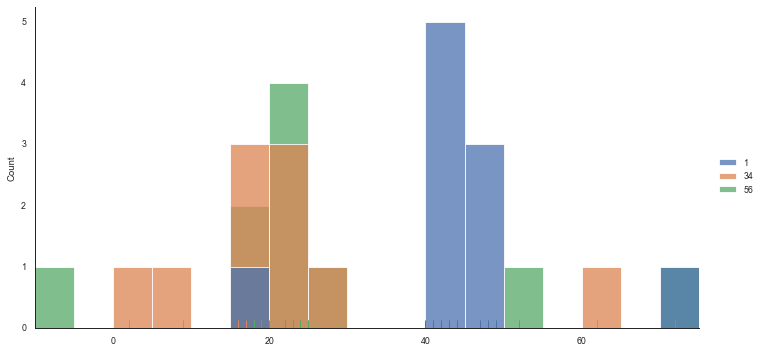

In [112]:
sns.set_context('paper')
impday_df = pd.DataFrame(data=[all1_days, all34_days, all56_days], index=[1,34,56])
sns.displot(data=impday_df.T, aspect=2,binwidth=5, multiple='fill', rug=True)
impday_df
#sns.histplot(all1_days, label=1, binwidth=1)
#sns.histplot(all34_days, label=34, color='r', binwidth=1)
#sns.histplot(all56_days, label=56, color='g', binwidth=1)
#plt.legend()

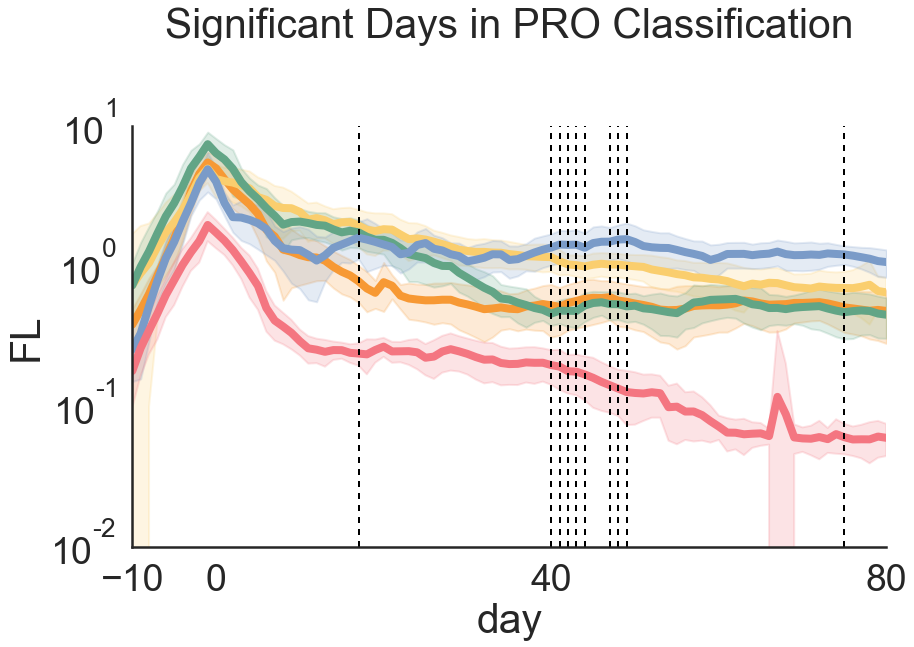

In [90]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds1, #col='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.6,lw=8, height=8,
            x='day', y='FL', kind='line', hue='PRO', legend=False, 
            hue_order=porder, palette=ppallete).set(xticks=[-10, 0, 40, 80])

axes = g.fig.axes
for ax, dlist in zip(axes, [all1_days]) :
    for d in dlist:
        ax.axvline(d, ls='--', lw=2, color='black')
              
plt.title('Significant Days in PRO Classification', y=1.2)            
g.set(yscale='log')
plt.show()


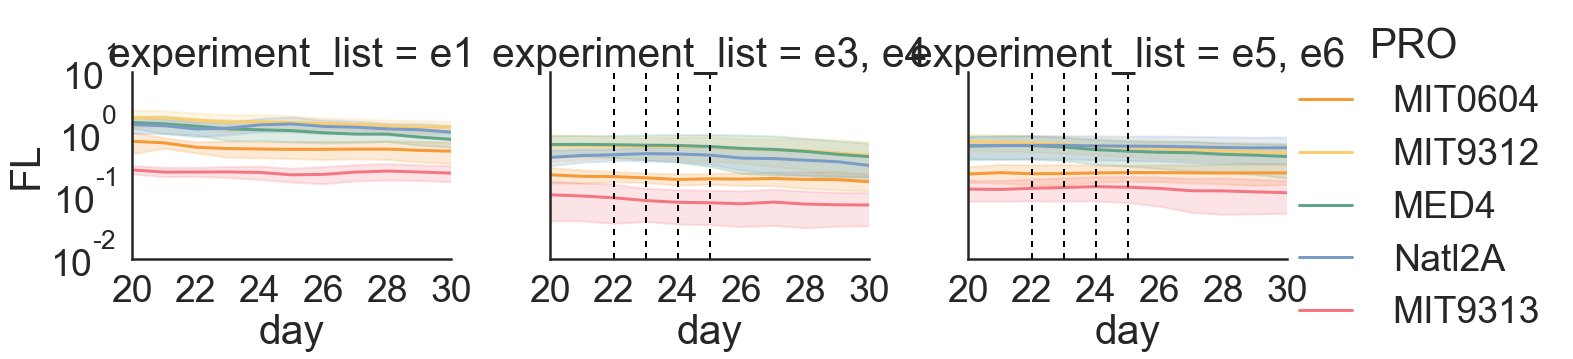

In [91]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, col='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.2,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)

axes = g.fig.axes
for ax, dlist in zip(axes, [all1_days, all34_days, all56_days]) :
    for d in dlist:
        ax.axvline(d, ls='--', lw=2, color='black')
              
g.set(yscale='log')
g.set(xlim=(20,30))
plt.show()


In [92]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day       FL  \
5           e1, 10A         e1    10A  MIT0604  DE  Co_Culture  -10  0.37325   
6           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -9  0.44400   
7           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -8  0.69700   
8           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -7  0.95000   
9           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -6  1.20300   

  experiment_list  decline  
5              e1  0.37325  
6              e1  0.44400  
7              e1  0.69700  
8              e1  0.95000  
9              e1  1.20300

# cluster by decline

## PCA 5 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_context('talk')
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=70, alpha=0.8, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )


In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            style='experiment',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            style='PRO',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 4 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 3,4 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# PCA 1 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# Heatmaps

In [ ]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [ ]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [ ]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

In [ ]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [ ]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

In [ ]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [ ]:
scores34_df.nlargest(20)

In [ ]:
scores56_df.nlargest(20)

In [ ]:
metadf